In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')
%matplotlib inline

from helpers import *

In [5]:
LOG_DIR = '../dump/logs/'
logs = os.listdir(LOG_DIR)
net_archs = np.unique([log.split('-')[2]+'-' for log in logs])
net_archs

logs_final = []
for log in logs:
    losses = get_losses(LOG_DIR+log)
    losses = np.array([np.insert(losses[1],0,99),np.insert(losses[0],0,99)])
    logs_final.append([log+'-final-imageset_val', np.mean(losses[1][290:-1]), losses[1]])
    logs_final.append([log+'-final-imageset_train', np.mean(losses[0][290:-1]), losses[0]])
    
    
log_df = pd.DataFrame(columns=["log", "final loss", "full loss"], data=logs_final)
log_df['arch'] = log_df['log'].apply(lambda x : str(x.split('-')[2])+'-')
log_df['seed'] = log_df['log'].apply(lambda x : int(catch(x, 'seed')))
log_df['imageset'] = log_df['log'].apply(lambda x : catch(x, 'imageset'))
log_df.head()

,log,final loss,full loss,arch,seed,imageset
0,seed_3-drop_0-vgg1_sc_bn-log-final-imageset_val,61.21872,"[99.0, 93.5156, 87.5392, 83.9843, 83.6718, 83....",vgg1_sc_bn-,3,val
1,seed_3-drop_0-vgg1_sc_bn-log-final-imageset_train,61.14500,"[99.0, 90.01, 83.19, 82.42, 80.99, 79.61, 78.9...",vgg1_sc_bn-,3,train
2,seed_1-drop_0-vgg1_mp_sc_bn-log-final-imageset...,57.71485,"[99.0, 90.0782, 79.8829, 79.60929999999999, 77...",vgg1_mp_sc_bn-,1,val
3,seed_1-drop_0-vgg1_mp_sc_bn-log-final-imageset...,57.24400,"[99.0, 81.03999999999999, 77.83, 75.26, 73.61,...",vgg1_mp_sc_bn-,1,train
4,seed_3-drop_0-vgg1_mp_sc-log-final-imageset_val,51.36328,"[99.0, 89.1407, 81.9141, 80.8205, 78.5156, 78....",vgg1_mp_sc-,3,val


Text(0,0.5,'ID')

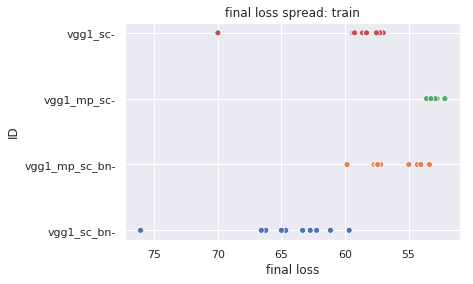

In [6]:
ax = sns.scatterplot(x='final loss',y='arch', hue='arch', legend=False, data=log_df.query('imageset == "train"'))
ax.invert_xaxis()
ax.set_title('final loss spread: train')
ax.set_ylabel('ID')

Text(0,0.5,'ID')

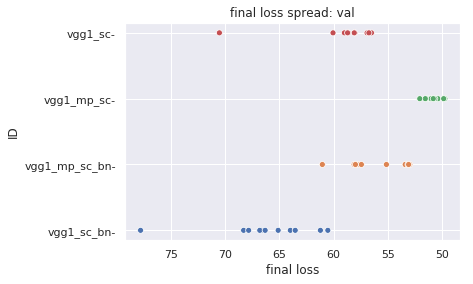

In [7]:
ax = sns.scatterplot(x='final loss',y='arch', hue='arch', legend=False, data=log_df.query('imageset == "val"'))
ax.invert_xaxis()
ax.set_title('final loss spread: val')
ax.set_ylabel('ID')

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

def match_strings(strings, path):
    return all([string in path for string in strings])

def load_data(mani_dir, exclude=[]):
    paths = np.sort(np.array(os.listdir(mani_dir)))
    if len(exclude)>0:
        paths = [path for path in paths if not match_strings(exclude, path)] 
    data = np.array([loadmat(mani_dir+path) for path in paths])
    return paths, data

def get_layer_type(path, types):
    for t in types:
        if t in path:
            return t

def frame_constructor(paths, data, key, tag=None, mean=False, verbose=False):
    perm_seed = [catch(path, 'seed') for path in paths]
    ft_size = [path.split('_')[1] for path in paths]
    lnum = [path.split('-')[2].split('_')[1] for path in paths]
    coding = [path.split('-')[2].split('_')[0] for path in paths]
    epochs = np.array([path.split('-')[1].split('_')[1] for path in paths])
    image_set = np.array([path.split('-')[0] for path in paths])
    
    data_vec = np.array([np.squeeze(datum[key]) for datum in data])
    if mean:
        data_vec = np.mean(data_vec,axis=1)
    data_vec = np.atleast_2d(data_vec)    
    if verbose:
        print('data_vec.shape: ', data_vec.shape)
    if data_vec.shape[0]<data_vec.shape[1]:
        data_vec = data_vec.T
        
    df = pd.DataFrame(
        columns=[
            'path', 
            'imageset',
            'epoch',
            'layer number',
            'coding',
            'seed', 
            'feature size', 
            'value', 
            'measure',
            'tag'
        ], 
        data=np.array([
            np.repeat([paths],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([image_set],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([epochs],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([lnum],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([coding],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([perm_seed],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([ft_size],data_vec.shape[-1],axis=0).T.reshape(-1),
            data_vec.reshape(-1),
            np.repeat(key,data_vec.size),
            np.repeat(tag,data_vec.size)
        ]).T
    )
    
    types = ['input', 'MaxPool2d', 'Conv2d', 'ReLU', 'Linear', 'BatchNorm2d']
    df['type'] = df.path.apply(lambda x: get_layer_type(x, types))
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')
    df['seed'] = pd.to_numeric(df['seed'], errors='coerce')
    df['feature size'] = pd.to_numeric(df['feature size'], errors='coerce')
    df['layer number'] = pd.to_numeric(df['layer number'], errors='coerce')
    df.loc[df['coding']=='features', 'layer number'] += 1
    df.loc[df['coding']=='classifier', 'layer number'] = df.loc[
        df['coding']=='classifier', 'layer number'] + df[
        (df['coding']=='features') & (df['imageset']=='train') & (df['epoch']==1) # this breaks if epoch 1 is not in the mix..
    ].shape[0]    
    
    return df


def compile_info(mani_dir, path):
    mani_dir.replace('manifold_', '-')
    info = path.replace('.h5', '')
    info += '-seed_'+catch(mani_dir, 'seed', ind=1)
    
    return info

def multi_frame_constructor(mani_dirs, tags, measures, exclude=[], verbose=False):
    df = None
    for i, mani_dir in enumerate(mani_dirs):
        paths, data = load_data(mani_dir, exclude=exclude)
        paths_info = [compile_info(mani_dir, path) for path in paths]
#         print(paths_info)
        for measure in measures:
            mean = True
            if measure in ['CCcorr', 'pr', 'K0', 'S_vec']: mean = False
            if type(df) == type(None):
                df = frame_constructor(paths_info, data, measure, tag=tags[i], mean=mean, verbose=verbose)
            else:
                df = df.append(frame_constructor(paths_info, data, measure, tag=tags[i], mean=mean))
    return df
  
def make_contiguous(a):
    return np.arange(len(a))
    
def display(df, measure, coding, title, opts={'sortby':[], 'hue':'tag', 'fix_legend':False, 'dims': (12,7)}):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure)
#         &(df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    xlabels = data['type'].values[::len(unique_tags)]
    
    if len(opts['sortby'])>0:
        data = data.sort_values(by=opts['sortby'])
    
    fig, ax = plt.subplots(figsize=opts['dims'])
    p = sns.cubehelix_palette(len(unique_tags), start=2, rot=0, dark=0, light=.80)
    ax = sns.scatterplot(x="type", 
                         y="value", 
#                          units="tag",
                         size='tag',
                         sizes=(150,150),
                         ax=ax,
                         hue=opts['hue'],
                         palette=p,
                         data=data)

    if opts['fix_legend']:
        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:1+len(unique_tags)], labels[0:1+len(unique_tags)], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(xlabels,rotation=90)
    ax.set_xlabel('layer type')
    return data

def get_losses(log, epochs=300, accuracy=False):
    f = open(log)
    val_loss = np.array([float(line.split(' ')[3]) for line in f if " * Prec@1" in line])
    f = open(log)
    train_loss = np.array([float(line.split(" ")[8]) for line in f if ("Prec@1" in line) & ("Epoch" in line)])
    step_num = len(train_loss)/epochs
    train_loss = np.array([train_loss[i*step_num:i*step_num+step_num].mean() for i in range(epochs)])
    
    if not accuracy:
        val_loss = 100-val_loss
        train_loss = 100-train_loss
    
    return train_loss, val_loss

def delta_data(df):
    layer_nums = np.unique(df['layer number'])
    measure_id = df.loc[df['type']=='input', 'measure'].values
    deltas = np.zeros([layer_nums.shape[0], measure_id.shape[0]]).astype('object')
    deltas[0,:] = measure_id
    for n in layer_nums:
        if n > 0:
            deltas[n,:] = df.loc[df['layer number']==n, 'value'].values - df.loc[df['layer number']==n-1, 'value'].values

    return deltas.T

def get_delta_frame(dir_template, ep, seeds=10, expand_input_files=False):
    for seed in range(seeds):
        if seed == 2:
            pass
        else:
            measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
            mani_dirs = [dir_template.format(seed)]
            tags = ["seed_{}".format(seed)]

            if expand_input_files:
                expand_input(mani_dirs)
            
            df = multi_frame_constructor(mani_dirs, tags, measures)
            df = add_volume(df)

            df = df[(df['imageset']=='train')&(df['epoch']==ep)]

            data = delta_data(df)
            
            columns = layer_types = df.sort_values(by=['layer number'])['type'].unique()
            columns[0] = 'measure'
            
            if seed == 0:
                delta_df = pd.DataFrame(columns=columns, data=data)
            else:
                delta_df = delta_df.append(pd.DataFrame(columns=columns, data=data))
    
    return delta_df

def plot_losses(log):
    train_loss, val_loss = get_losses(log)
    ax = pd.DataFrame(columns=['training error', 'validation error'], data=np.array([train_loss, val_loss]).T).plot()
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('Error (%)')
    ax.set_title('Training curves')
    
def delta_plot(delta_df, x, y, name):
    xy_df = delta_df[delta_df['measure']==x].melt('measure')
    y_df = delta_df[delta_df['measure']==y].melt('measure')
    xy_df['value2'] = y_df['value'].values

    ax = sns.scatterplot(x='value', y='value2', hue='variable', data=xy_df)
    ax.set_xlabel('delta '+x.replace('_vec',''))
    ax.set_ylabel('delta '+y.replace('_vec',''))
    ax.hlines(0,xy_df['value'].min()-.5,xy_df['value'].max()+.5)
    ax.vlines(0,xy_df['value2'].min()-.5,xy_df['value2'].max()+.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_title('{}, d{} vs d{}'.format(name, x, y))
    
def catch(filepath, target, ind=1):
    parts = filepath.split('-')
    match = [part for part in parts if target in part]
    if len(match) == 1:
        return match[0].split('_')[ind]
    else:
        print('target {} not found in filepath {}'.format(target,filepath))
        return None

def get_meta_dict(filepath,targets):
    """get_meta_dict(fs, ['seed', 'drop', 'imageset'])"""
    meta_dict = {}
    for target in targets:
        meta_dict[target] = catch(filepath,target)
        
    return meta_dict

def add_meta(df,targets):
    for target in targets:
        df[target] = df['log'].apply(lambda x : catch(x,target))
        
def add_volume(df):
    v_df = df.loc[df['measure']=='D_M_vec'].copy()
    v_df['measure'] = 'Rm*sqrt(Dm)'
    v_df['value'] = np.sqrt(df.loc[df['measure']=='D_M_vec', 'value'].values)*df.loc[df['measure']=='R_M_vec', 'value'].values
    return df.append(v_df)

def expand_input(mani_dirs):
    from shutil import copyfile 

    for md in mani_dirs:
        files = os.listdir(md)
        eps = np.unique([catch(p, 'ep_') for p in files if not match_strings(['input'], p)])
        inputs = [p for p in files if match_strings(['-input'], p)]
        template = files[0]

        for og_file in inputs:
            for ep in eps:
                og_file_path = os.path.join(md, og_file)
                dest = og_file.replace('-', '-ep_{}-'.format(ep)).replace('input', 'layer_0-type_input-features_3072')
                dest = os.path.join(md, dest)
                copyfile(og_file_path, dest)
            os.remove(og_file_path)

### median performance run, no MP or BN

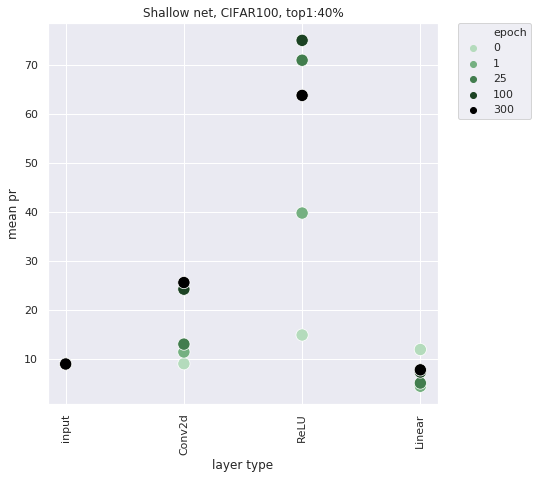

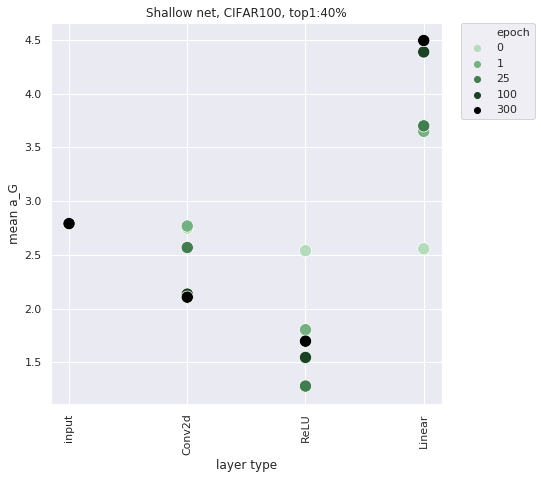

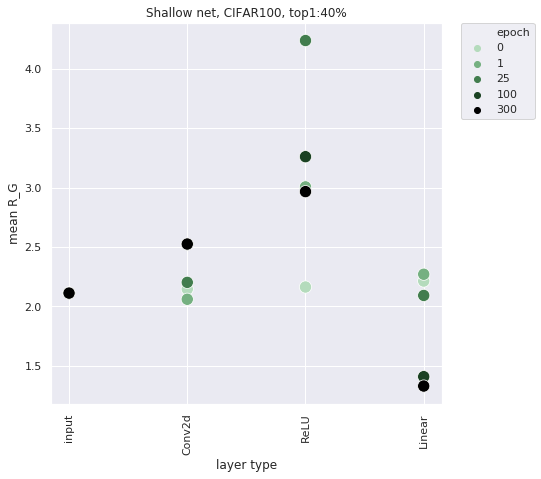

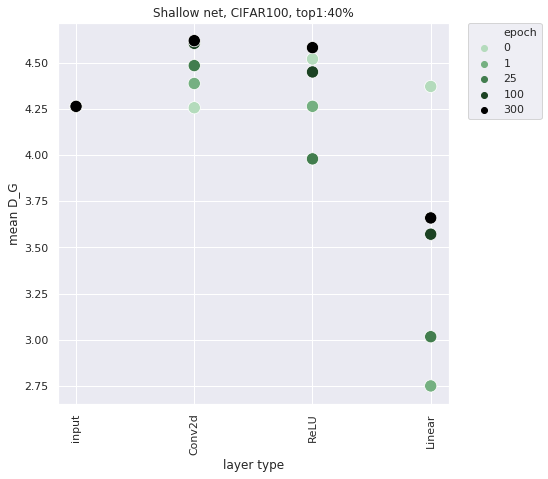

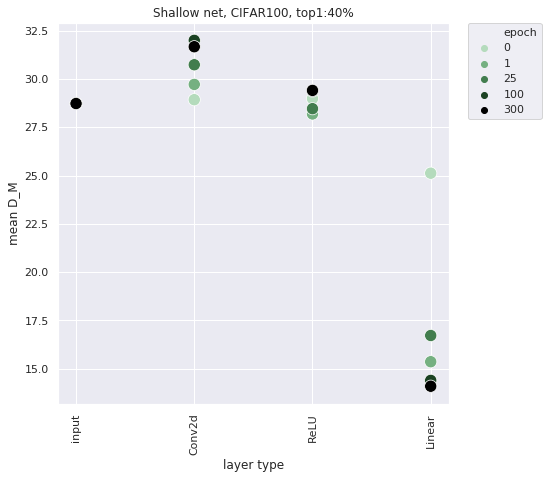

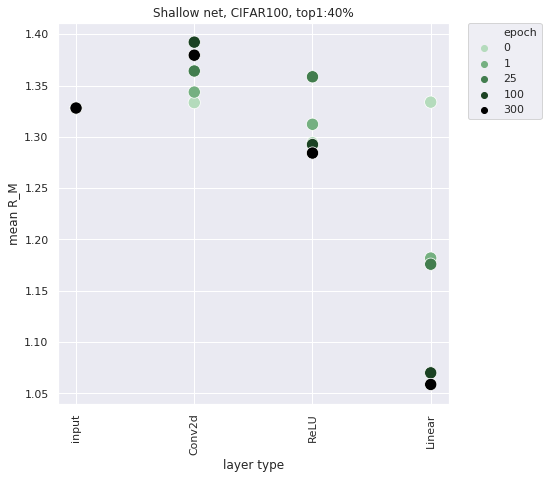

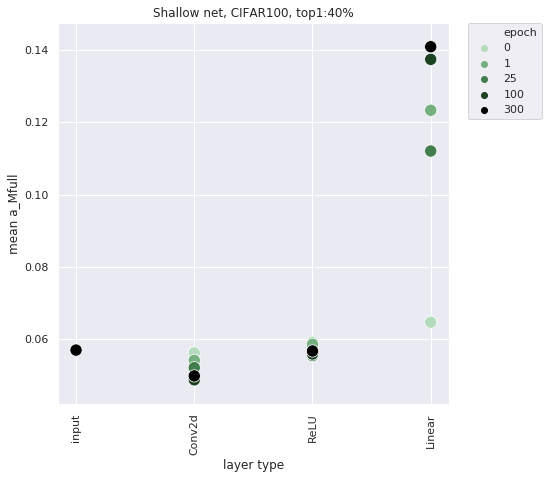

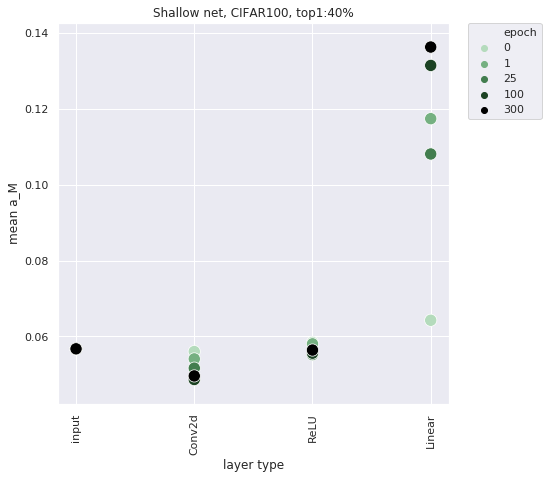

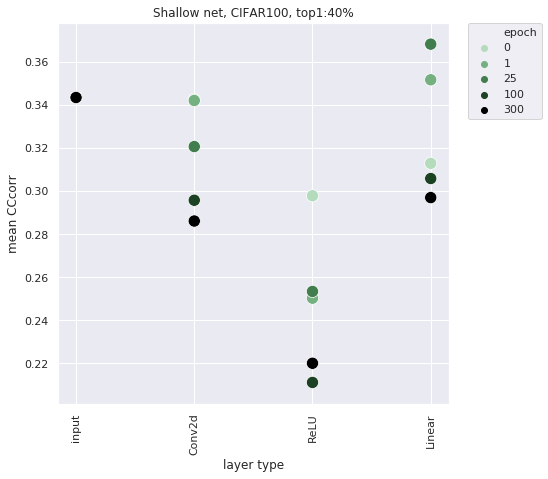

In [275]:
measures = ['pr', 'a_G_vec', 'R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold-seed_4-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/'
]

tags = [ 
    "seed_0 ep:" 
]

# df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df = multi_frame_constructor(mani_dirs, tags, measures)

df['tag'] = df['tag']+df['epoch'].astype(str)

opts = {
    'dims':[7,7],
    'sortby': ['layer number','epoch'],
    'hue': 'epoch',
    'fix_legend':True
}

# df_filtered = df[(df['imageset']=='train')&(df['epoch']==300)]
df_filtered = df[(df['imageset']=='train')]

# r*d**(1/2)

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net, CIFAR100, top1:40%', opts=opts)

### median performance run, MP no BN

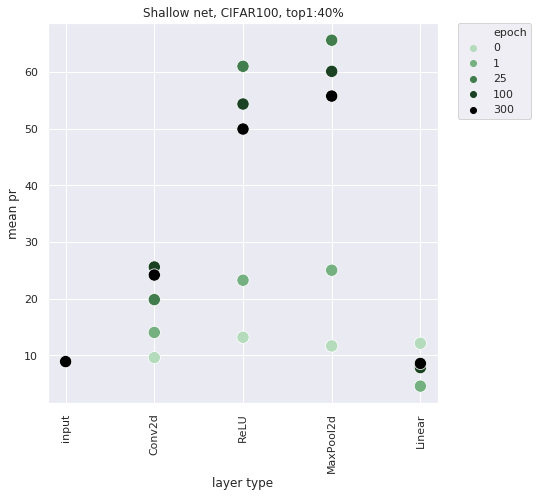

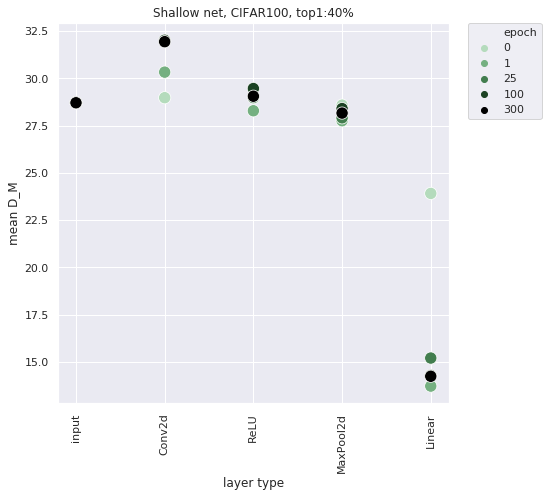

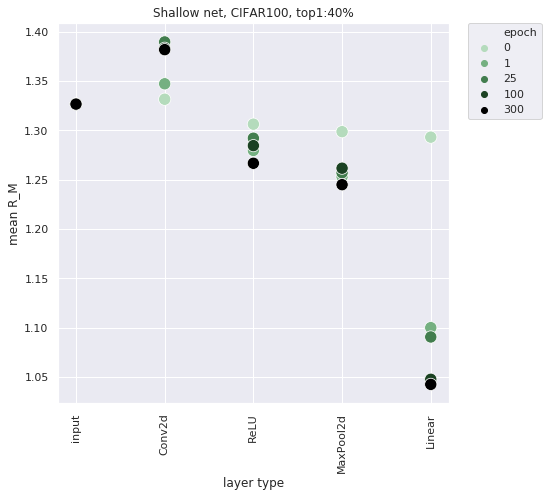

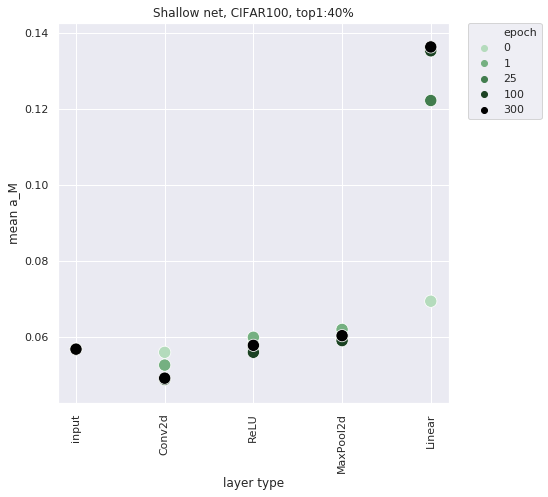

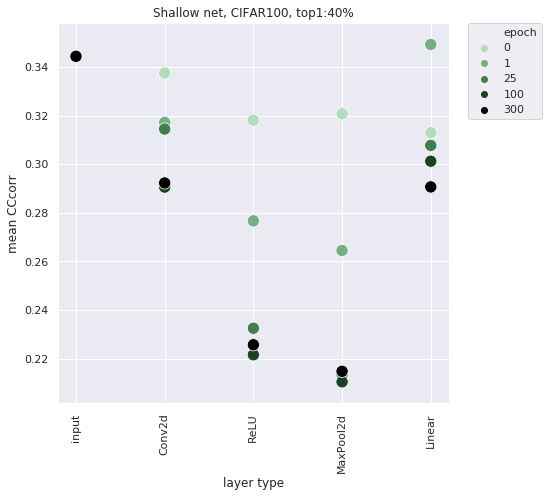

In [283]:
# measures = ['pr', 'a_G_vec', 'R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_M_vec', 'CCcorr']
measures = ['pr', 'D_M_vec','R_M_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold-seed_8-drop_0-vgg1_mp_sc-formatted_features-sort_betasoftmax/'
]
# expand_input(mani_dirs)

tags = [ 
    "seed_0 ep:" 
]

# df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df = multi_frame_constructor(mani_dirs, tags, measures)

df['tag'] = df['tag']+df['epoch'].astype(str)

opts = {
    'dims':[7,7],
    'sortby': ['layer number','epoch'],
    'hue': 'epoch',
    'fix_legend':True
}

# df_filtered = df[(df['imageset']=='train')&(df['epoch']==300)]
df_filtered = df[(df['imageset']=='train')]

# r*d**(1/2)

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net, CIFAR100, top1:40%', opts=opts)

### median performance run, BN no mp

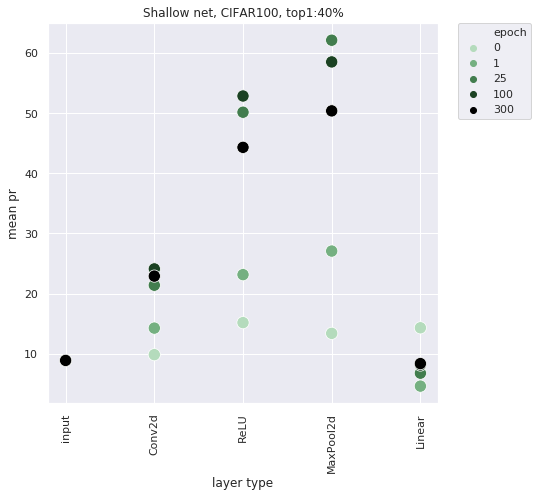

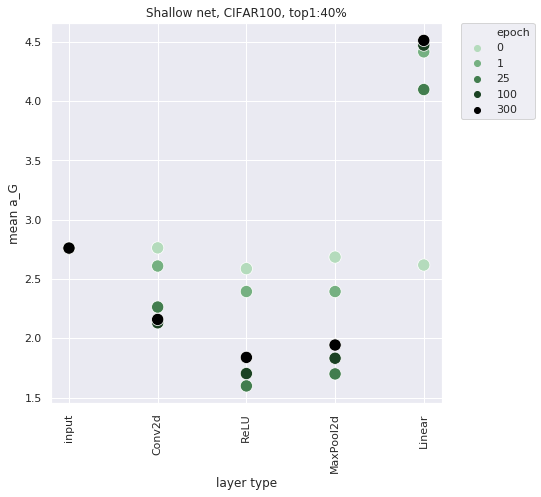

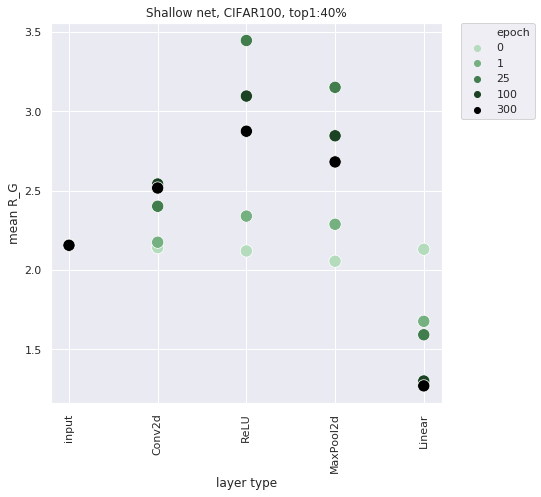

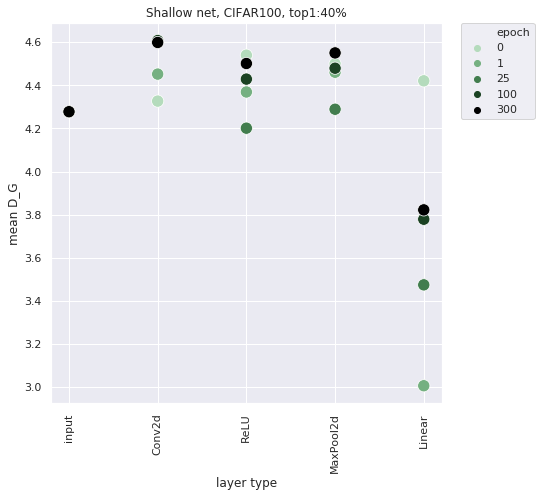

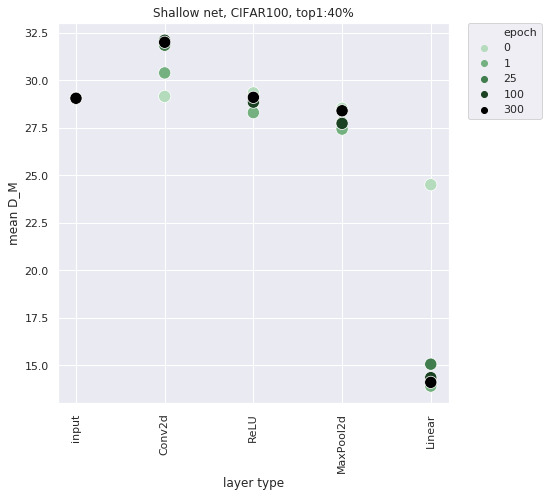

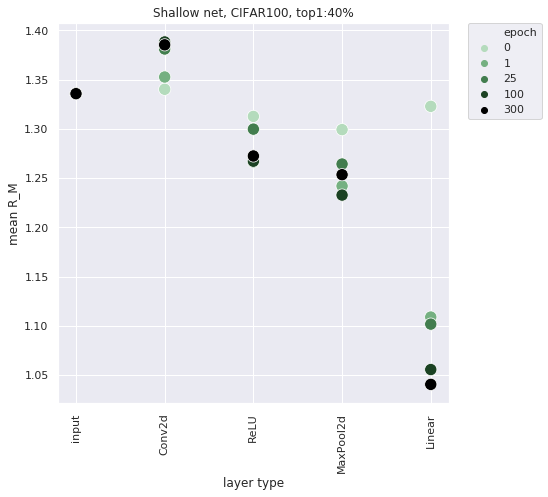

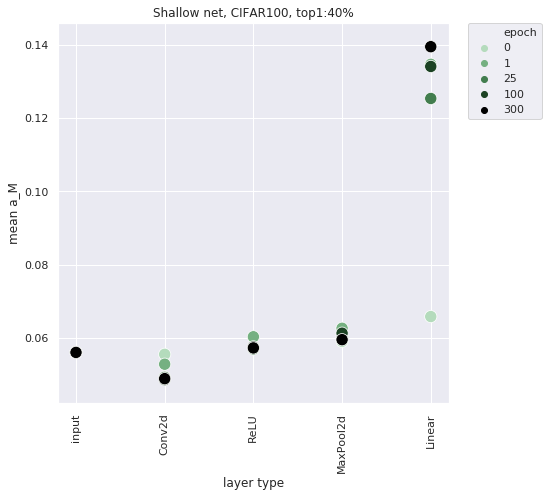

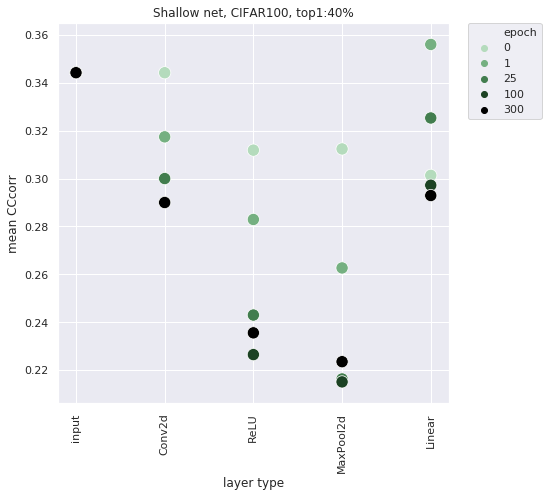

In [278]:
measures = ['pr', 'a_G_vec', 'R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold-seed_9-drop_0-vgg1_mp_sc-formatted_features-sort_betasoftmax/'
]
expand_input(mani_dirs)

tags = [ 
    "seed_0 ep:" 
]

# df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df = multi_frame_constructor(mani_dirs, tags, measures)

df['tag'] = df['tag']+df['epoch'].astype(str)

opts = {
    'dims':[7,7],
    'sortby': ['layer number','epoch'],
    'hue': 'epoch',
    'fix_legend':True
}

# df_filtered = df[(df['imageset']=='train')&(df['epoch']==300)]
df_filtered = df[(df['imageset']=='train')]

# r*d**(1/2)

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net, CIFAR100, top1:40%', opts=opts)

### median performance run, MP and BN

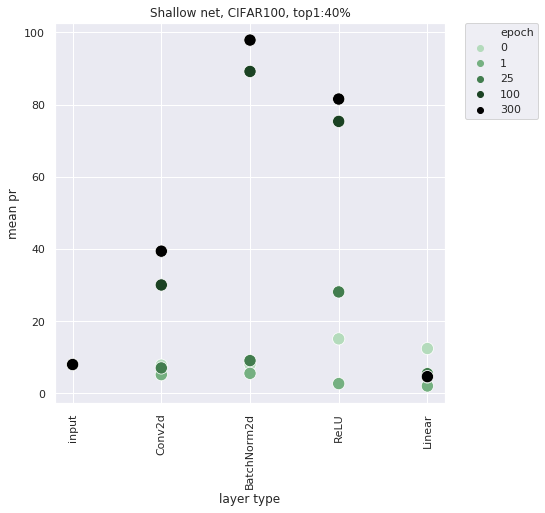

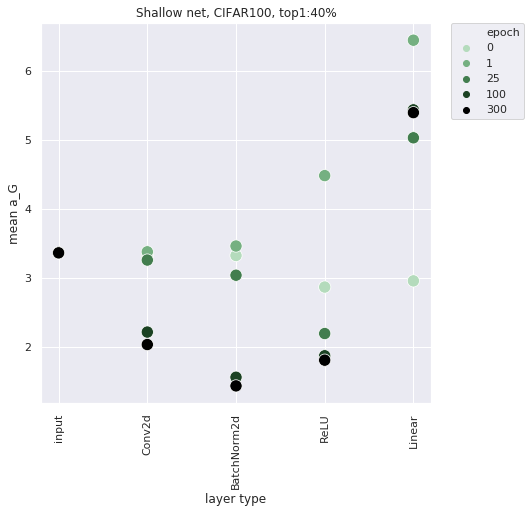

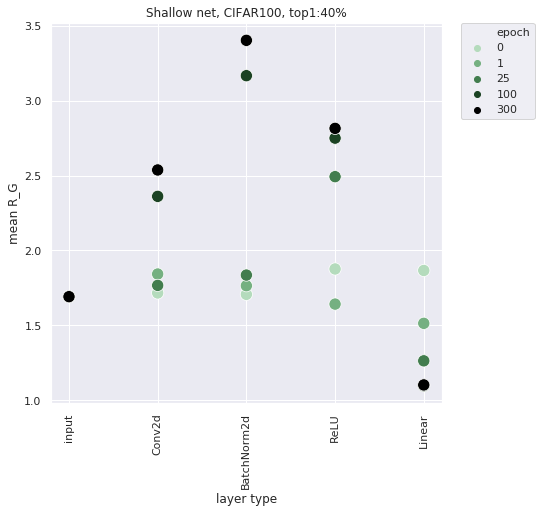

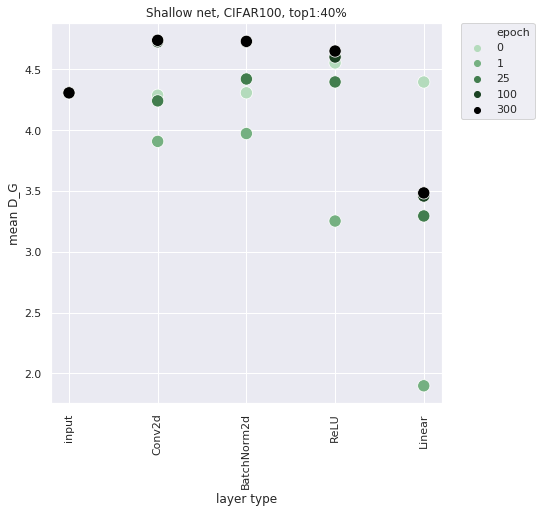

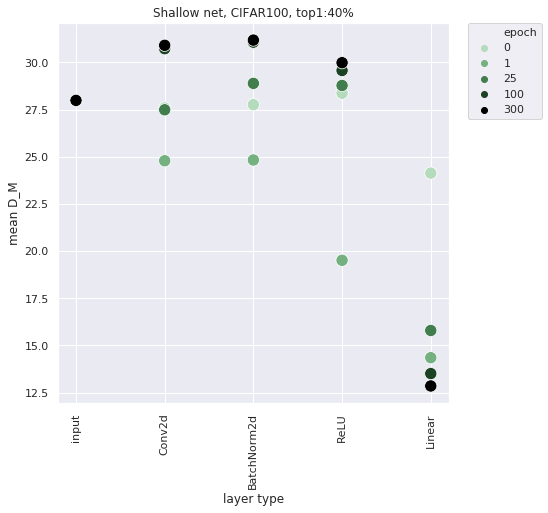

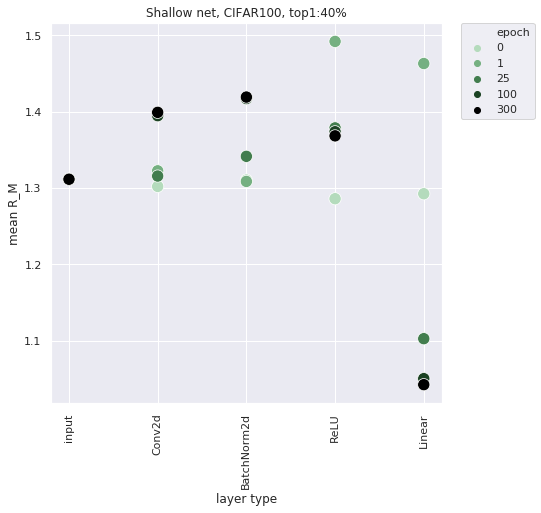

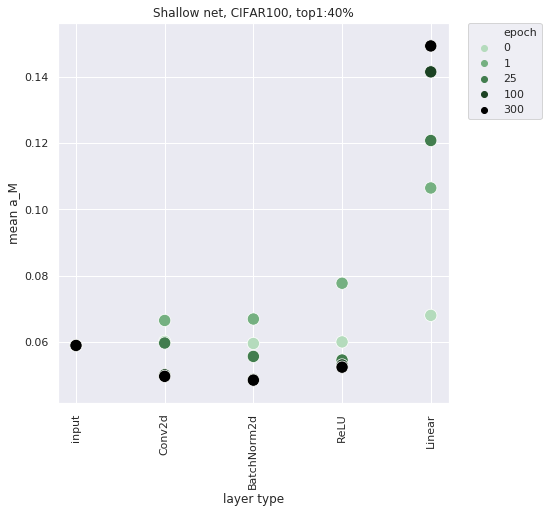

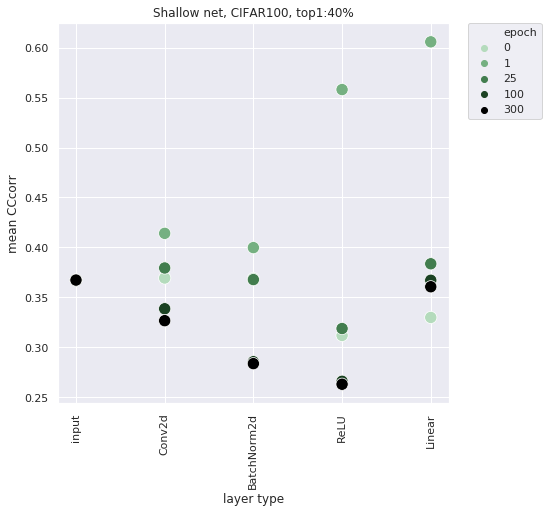

In [279]:
measures = ['pr', 'a_G_vec', 'R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold-seed_6-drop_0-vgg1_sc_bn-formatted_features-sort_betasoftmax/'
]
# expand_input(mani_dirs)

tags = [ 
    "seed_0 ep:" 
]

# df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df = multi_frame_constructor(mani_dirs, tags, measures)

df['tag'] = df['tag']+df['epoch'].astype(str)

opts = {
    'dims':[7,7],
    'sortby': ['layer number','epoch'],
    'hue': 'epoch',
    'fix_legend':True
}

# df_filtered = df[(df['imageset']=='train')&(df['epoch']==300)]
df_filtered = df[(df['imageset']=='train')]

# r*d**(1/2)

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net, CIFAR100, top1:40%', opts=opts)

## delta plot Conv, Relu, FC

In [8]:
dir_template = '../dump/manifold_seed_{}-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/'
delta_df = get_delta_frame(dir_template, 300)
delta_df.tail(10)

,measure,Conv2d,ReLU,Linear
6,CCcorr,-0.0380061,-0.0760366,0.0678504
7,Rm*sqrt(Dm),0.682582,-1.03744,-2.9165
0,R_G_vec,0.361734,0.351989,-1.44988
1,D_G_vec,0.343705,-0.0624884,-0.87111
2,D_M_vec,3.17735,-2.78065,-14.8397
3,R_M_vec,0.0613486,-0.11573,-0.231893
4,a_Mfull_vec,-0.00872929,0.00914305,0.0848222
5,a_M_vec,-0.00855024,0.00912767,0.0829528
6,CCcorr,-0.0358009,-0.0667335,0.0610915
7,Rm*sqrt(Dm),0.72898,-0.969111,-2.94318


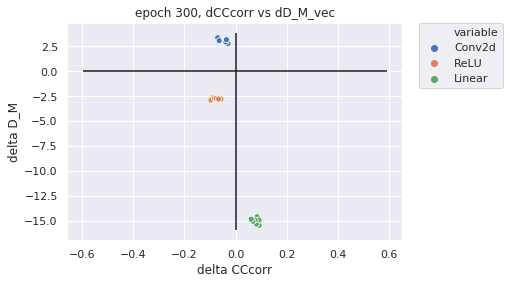

In [9]:
x = 'D_M_vec'
y = 'CCcorr'
delta_plot(delta_df,y,x, 'epoch 300')

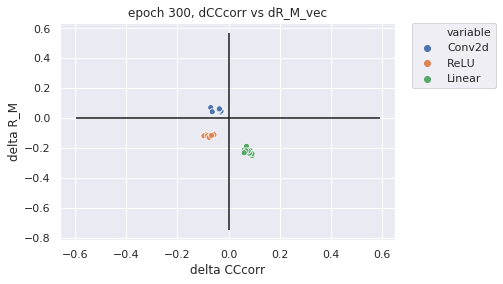

In [10]:
x = 'R_M_vec'
y = 'CCcorr'
delta_plot(delta_df,y,x, 'epoch 300')

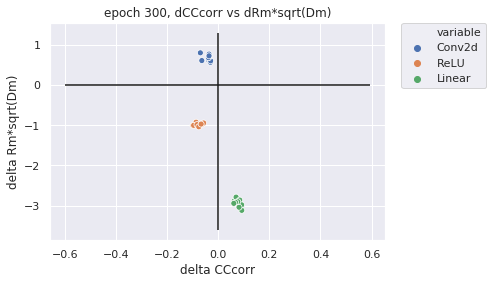

In [11]:
x = 'Rm*sqrt(Dm)'
y = 'CCcorr'
delta_plot(delta_df,y,x, 'epoch 300')

## delta plot Conv, Relu, MP, FC

In [211]:
dir_template = '../dump/manifold-seed_{}-drop_0-vgg1_mp_sc-formatted_features-sort_betasoftmax/'
delta_df = get_delta_frame(dir_template, 300,seeds=10, expand_input_files=True)
delta_df.tail(10)

,measure,Conv2d,ReLU,MaxPool2d,Linear
6,CCcorr,-0.0521268,-0.0665661,-0.0109405,0.0758841
7,Rm*sqrt(Dm),0.701235,-0.981528,-0.220789,-2.67273
0,R_G_vec,0.36098,0.357811,-0.193491,-1.41143
1,D_G_vec,0.32106,-0.0975195,0.0491031,-0.727873
2,D_M_vec,2.94859,-2.90046,-0.706538,-14.3002
3,R_M_vec,0.0495609,-0.11279,-0.0189823,-0.21276
4,a_Mfull_vec,-0.00722352,0.00858392,0.00242563,0.0843628
5,a_M_vec,-0.00715569,0.00838071,0.00225066,0.0798962
6,CCcorr,-0.054229,-0.0544318,-0.0120555,0.0694124
7,Rm*sqrt(Dm),0.636848,-0.972022,-0.184989,-2.77199


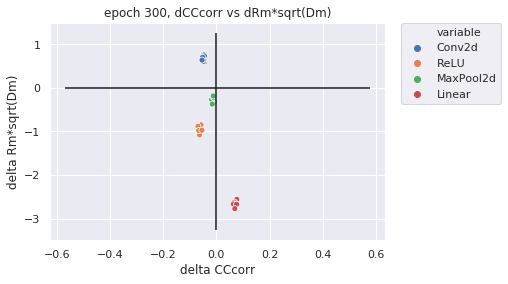

In [212]:
x = 'Rm*sqrt(Dm)'
y = 'CCcorr'
delta_plot(delta_df,y,x, 'epoch 300')

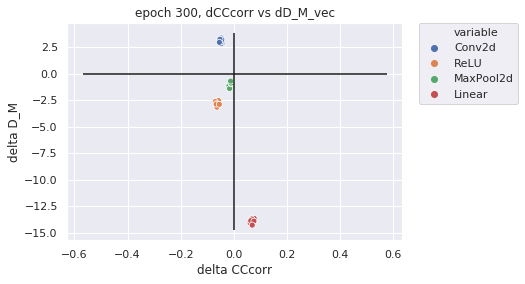

In [213]:
x = 'D_M_vec'
y = 'CCcorr'
delta_plot(delta_df,y,x, 'epoch 300')

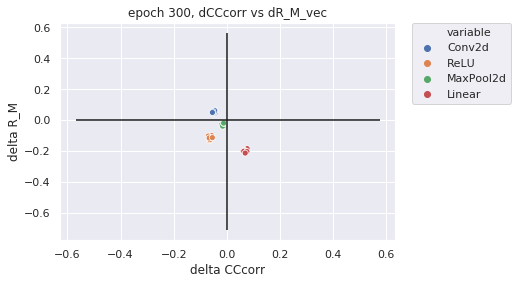

In [214]:
x = 'R_M_vec'
y = 'CCcorr'
delta_plot(delta_df,y,x, 'epoch 300')

## loss vs a_M in shallow classifier with no BN and no MP

In [225]:
measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']

arch = 'vgg1_sc-'
path_template = '../dump/manifold-seed_{}-drop_0-{}formatted_features-sort_betasoftmax/'.format('{}',arch)
tag_template = '{}'
seed_range = range(0,10)
mani_dirs = [path_template.format(i) for i in seed_range]
tags = [tag_template.format(i) for i in seed_range]

expand_input(mani_dirs)

df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df['loss'] = df.T.apply(lambda x : log_df[(log_df['seed'] == x.seed)&(log_df['imageset'] == x['imageset'])&(log_df['arch'] == arch)]['full loss'].values[0][x.epoch])
df['loss'] = pd.to_numeric(df['loss'], errors='coerce')

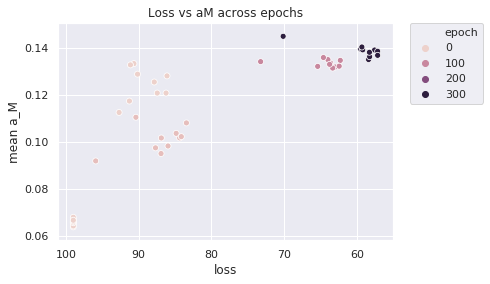

In [230]:
plot_df = df[(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]

ax = sns.scatterplot(x='loss', y='value', hue='epoch', data=plot_df)
ax.set_title('Loss vs aM across epochs')
ax.set_ylabel('mean a_M')
ax.invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

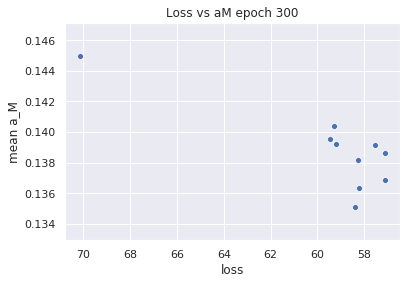

In [231]:
plot_df = df[(df['epoch']==300)&(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]
ax = sns.scatterplot(x='loss', y='value', data=plot_df)
ax.set_ylabel('mean a_M')
ax.set_title('Loss vs aM epoch 300')
ax.invert_xaxis()

## loss vs a_M in shallow classifier with MP, no BN

In [233]:
measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']

arch = 'vgg1_mp_sc-'
path_template = '../dump/manifold-seed_{}-drop_0-{}formatted_features-sort_betasoftmax/'.format('{}',arch)
tag_template = '{}'
seed_range = range(0,10)
mani_dirs = [path_template.format(i) for i in seed_range]
tags = [tag_template.format(i) for i in seed_range]

expand_input(mani_dirs)

df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df['loss'] = df.T.apply(lambda x : log_df[(log_df['seed'] == x.seed)&(log_df['imageset'] == x['imageset'])&(log_df['arch'] == arch)]['full loss'].values[0][x.epoch])
df['loss'] = pd.to_numeric(df['loss'], errors='coerce')

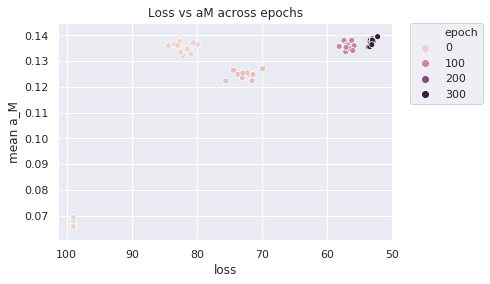

In [234]:
plot_df = df[(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]

ax = sns.scatterplot(x='loss', y='value', hue='epoch', data=plot_df)
ax.set_title('Loss vs aM across epochs')
ax.set_ylabel('mean a_M')
ax.invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

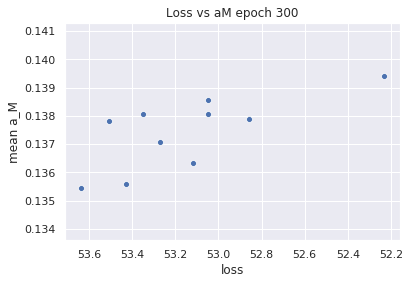

In [235]:
plot_df = df[(df['epoch']==300)&(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]
ax = sns.scatterplot(x='loss', y='value', data=plot_df)
ax.set_ylabel('mean a_M')
ax.set_title('Loss vs aM epoch 300')
ax.invert_xaxis()

## loss vs a_M in shallow classifier with BN, no MP

In [215]:
measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']

arch = 'vgg1_sc_bn-'
path_template = '../dump/manifold-seed_{}-drop_0-{}formatted_features-sort_betasoftmax/'.format('{}',arch)
tag_template = '{}'
seed_range = range(0,10)
mani_dirs = [path_template.format(i) for i in seed_range]
tags = [tag_template.format(i) for i in seed_range]

expand_input(mani_dirs)

df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df['loss'] = df.T.apply(lambda x : log_df[(log_df['seed'] == x.seed)&(log_df['imageset'] == x['imageset'])&(log_df['arch'] == arch)]['full loss'].values[0][x.epoch])
df['loss'] = pd.to_numeric(df['loss'], errors='coerce')

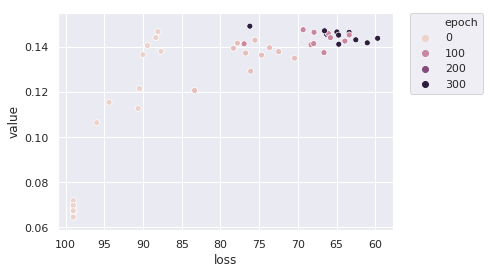

In [224]:
plot_df = df[(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]

ax = sns.scatterplot(x='loss', y='value', hue='epoch', data=plot_df)
ax.invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

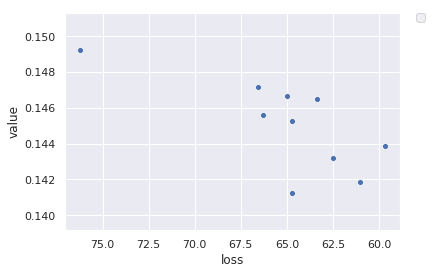

In [221]:
plot_df = df[(df['epoch']==300)&(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]
ax = sns.scatterplot(x='loss', y='value', data=plot_df)
ax.set_title()
ax.invert_xaxis()

## loss vs a_M in shallow classifier with BN and mp

In [241]:
measures = ['R_G_vec', 'D_G_vec', 'D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']

arch = 'vgg1_mp_sc_bn-'
path_template = '../dump/manifold-seed_{}-drop_0-{}formatted_features-sort_betasoftmax/'.format('{}',arch)
tag_template = '{}'
seed_range = range(0,10)
mani_dirs = [path_template.format(i) for i in seed_range]
tags = [tag_template.format(i) for i in seed_range]

expand_input(mani_dirs)

df = multi_frame_constructor(mani_dirs, tags, measures, exclude=['input'])
df['loss'] = df.T.apply(lambda x : log_df[(log_df['seed'] == x.seed)&(log_df['imageset'] == x['imageset'])&(log_df['arch'] == arch)]['full loss'].values[0][x.epoch])
df['loss'] = pd.to_numeric(df['loss'], errors='coerce')

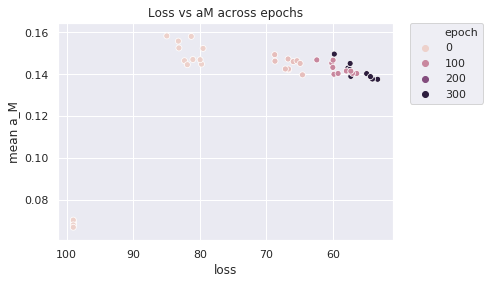

In [242]:
plot_df = df[(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]

ax = sns.scatterplot(x='loss', y='value', hue='epoch', data=plot_df)
ax.set_title('Loss vs aM across epochs')
ax.set_ylabel('mean a_M')
ax.invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

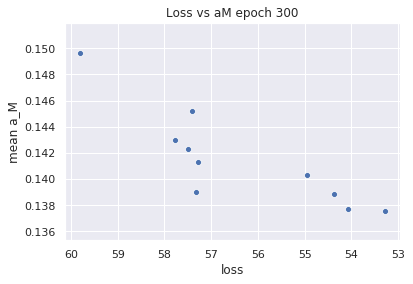

In [243]:
plot_df = df[(df['epoch']==300)&(df['measure']=='a_M_vec')&(df['type']=='Linear')&(df['imageset']=='train')]
ax = sns.scatterplot(x='loss', y='value', data=plot_df)
ax.set_ylabel('mean a_M')
ax.set_title('Loss vs aM epoch 300')
ax.invert_xaxis()

In [42]:
def general_delta_frame(df, measure, diff, at1, at2):
    new_df = df.loc[(df[measure[0]] == measure[1]) & (df[diff] == at2)].copy()
    new_df[diff] = new_df[diff].apply(lambda _ : "{}-{}".format(at2,at1))
    new_df['value'] = df.loc[(df[measure[0]] == measure[1]) & (df[diff] == at2), 'value'].values - df.loc[(df[measure[0]] == measure[1]) & (df[diff] == at1), 'value'].values
    return new_df

In [43]:
d_epoch_aM = general_delta_frame(df, ['measure','a_M_vec'], 'epoch', 300, 0)
d_epoch_aM = general_delta_frame(d_epoch_aM, 'a_M_vec', 'epoch', 300, 0)
d_epoch_aM.head()

,path,image set,epoch,layer number,coding,perm seed,feature size,value,measure,tag,type,loss
0,train-ep_0-classifier_1_Linear(in_features=655...,train,0-300,3,classifier,NaN,NaN,-0.072471,a_M_vec,0,Linear,99.0
1,"train-ep_0-features_0_Conv2d(3,_64,_kernel_siz...",train,0-300,1,features,NaN,NaN,0.007647,a_M_vec,0,Conv2d,99.0
2,train-ep_0-features_1_ReLU(inplace)-seed_seed,train,0-300,2,features,NaN,NaN,0.000385,a_M_vec,0,ReLU,99.0
15,val-ep_0-classifier_1_Linear(in_features=65536...,val,0-300,3,classifier,NaN,NaN,-0.050688,a_M_vec,0,Linear,99.0
16,"val-ep_0-features_0_Conv2d(3,_64,_kernel_size=...",val,0-300,1,features,NaN,NaN,0.004053,a_M_vec,0,Conv2d,99.0


In [39]:
d_epoch_aM[d_epoch_aM['layer number']==3]

,path,image set,epoch,layer number,coding,perm seed,feature size,value,measure,tag,type,loss
12,train-ep_300-classifier_1_Linear(in_features=6...,train,300-0,3,classifier,NaN,NaN,0.072471,a_M_vec,0,Linear,59.3100
27,val-ep_300-classifier_1_Linear(in_features=655...,val,300-0,3,classifier,NaN,NaN,0.050688,a_M_vec,0,Linear,59.4531
12,train-ep_300-classifier_1_Linear(in_features=6...,train,300-0,3,classifier,NaN,NaN,0.076651,a_M_vec,1,Linear,59.9900
27,val-ep_300-classifier_1_Linear(in_features=655...,val,300-0,3,classifier,NaN,NaN,0.048758,a_M_vec,1,Linear,59.2969
12,train-ep_300-classifier_1_Linear(in_features=6...,train,300-0,3,classifier,NaN,NaN,0.000002,a_M_vec,2,Linear,66.2700
27,val-ep_300-classifier_1_Linear(in_features=655...,val,300-0,3,classifier,NaN,NaN,-0.000040,a_M_vec,2,Linear,70.1563
12,train-ep_300-classifier_1_Linear(in_features=6...,train,300-0,3,classifier,NaN,NaN,0.070889,a_M_vec,3,Linear,61.0700
27,val-ep_300-classifier_1_Linear(in_features=655...,val,300-0,3,classifier,NaN,NaN,0.049885,a_M_vec,3,Linear,63.0857
12,train-ep_300-classifier_1_Linear(in_features=6...,train,300-0,3,classifier,NaN,NaN,0.073916,a_M_vec,4,Linear,58.4300
27,val-ep_300-classifier_1_Linear(in_features=655...,val,300-0,3,classifier,NaN,NaN,0.051717,a_M_vec,4,Linear,58.9062


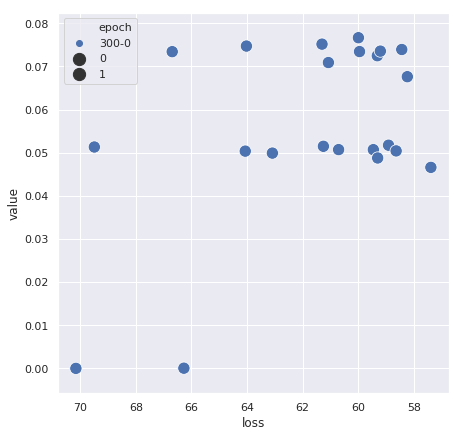

In [36]:
fig, ax = plt.subplots(figsize=opts['dims'])
# p = sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.80)
ax = sns.scatterplot(x='loss', 
                     y="value", 
#                          units="tag",
                     size=1,
                     sizes=(150,150),
                     ax=ax,
                     hue='epoch',
#                      palette=p,
                     data=d_epoch_aM[d_epoch_aM['layer number']==3])
#                      data=df[(df.measure==m)&(df['layer number']==l_num)])

# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[0:6], labels[0:6], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# measure_name = m.replace('_vec','')
ax.invert_xaxis()
# ax.set_title('{} in layer {} vs loss'.format(measure_name, l_num))
# ax.set_ylabel(measure_name)

In [ ]:
# sc~40 sc-mp~46 sc-bn~33, sc-bn-mp~42

ValueError: Could not interpret input 'loss'

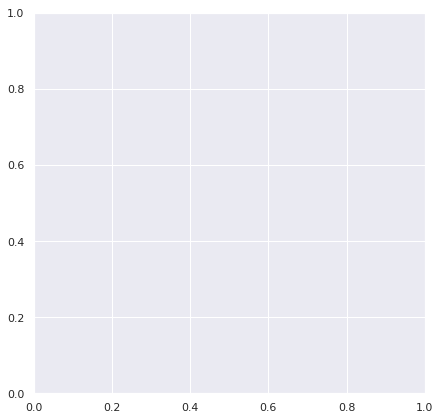

In [45]:
for m in measures:
    for l_num in range(1,4):
        fig, ax = plt.subplots(figsize=opts['dims'])
        p = sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.80)
        ax = sns.scatterplot(x='loss', 
                             y="value", 
        #                          units="tag",
                             size=1,
                             sizes=(150,150),
                             ax=ax,
                             hue='epoch',
                             palette=p,
                             data=df[(df.measure==m)&(df['layer number']==l_num)])

        handles, labels = ax.get_legend_handles_labels()
        l = plt.legend(handles[0:6], labels[0:6], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        measure_name = m.replace('_vec','')
        ax.invert_xaxis()
        ax.set_title('{} in layer {} vs loss'.format(measure_name, l_num))
        ax.set_ylabel(measure_name)

In [1]:
df.shape

NameError: name 'df' is not defined

## todo
plot correlation of measures with loss
fix frames to be better
compute 
 - gaussian capacity
 - gaussian mean width
add inputs to plots

fix PR, add VE dimensionality,

## Old results, based on random sampling of manifold points

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 34)
(1, 34)
(1, 34)
(1, 34)
(1, 34)


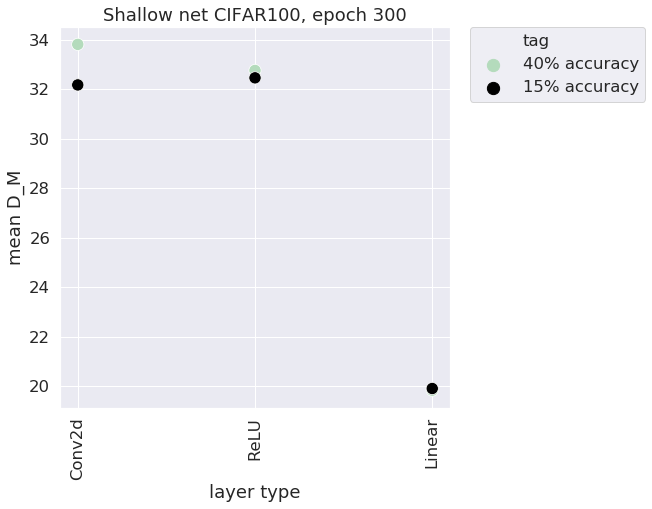

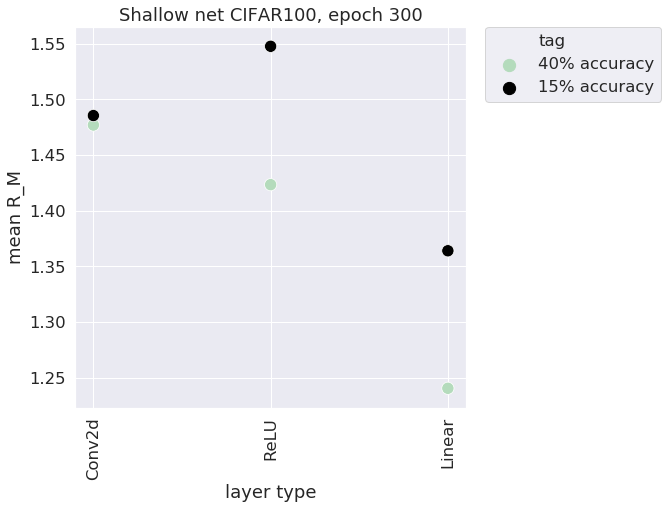

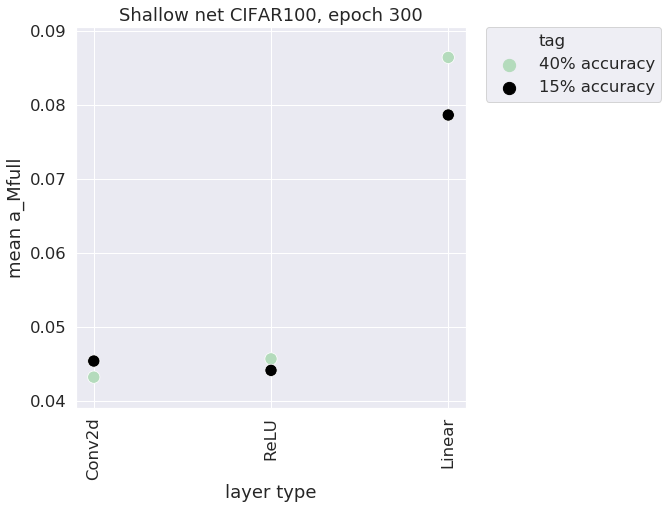

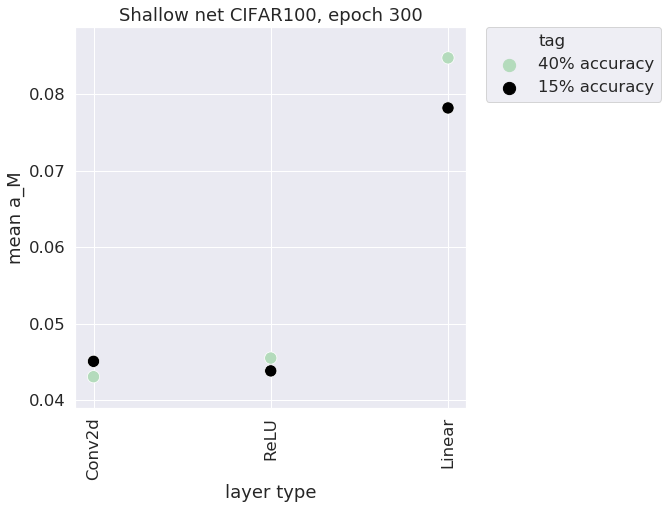

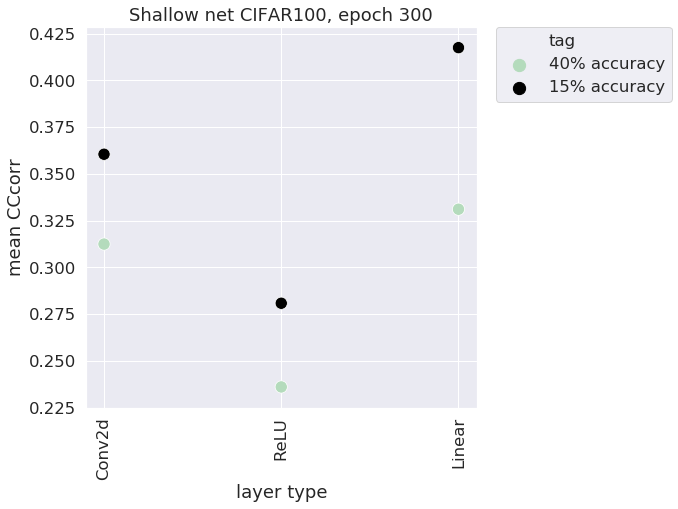

In [271]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_0-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_16-drop_0-vgg1_sc-formatted_features-sort_random/'
]

tags = [
    "40% accuracy",
    "15% accuracy" 
]

df = multi_frame_constructor(mani_dirs, tags, measures)

ep=300
df_filtered = df[(df['image set']=='train')&(df['epoch']==ep)]
df_filtered = df_filtered[(df_filtered['image set']=='train')&(df_filtered['type']!='BatchNorm2d')]


opts = {
    'dims':[7,7],
    'sortby': [],
    'hue': 'tag',
    'fix_legend':False
}

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow net CIFAR100, epoch {}'.format(ep), opts=opts)

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 48)
(1, 48)
(1, 48)
(1, 48)
(1, 48)


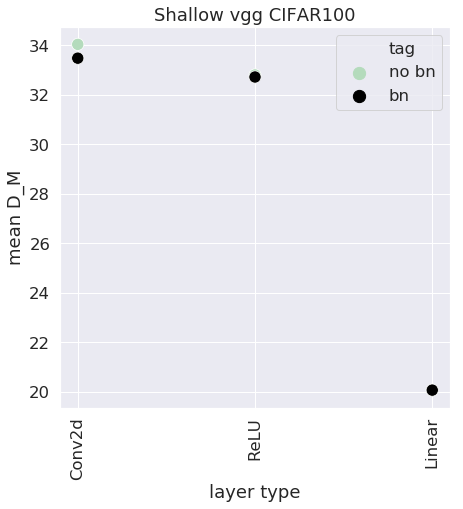

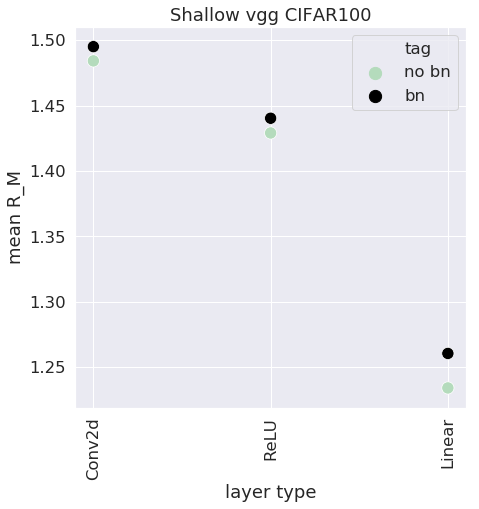

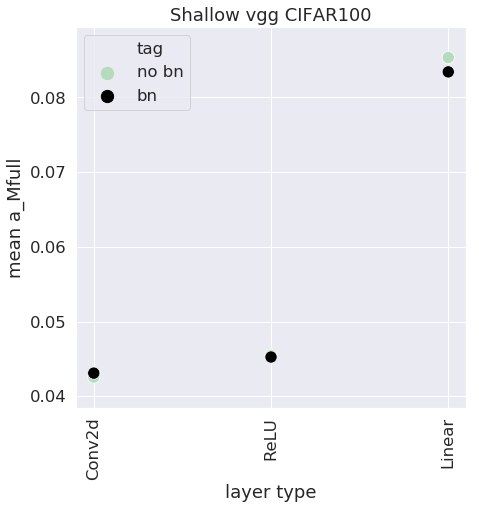

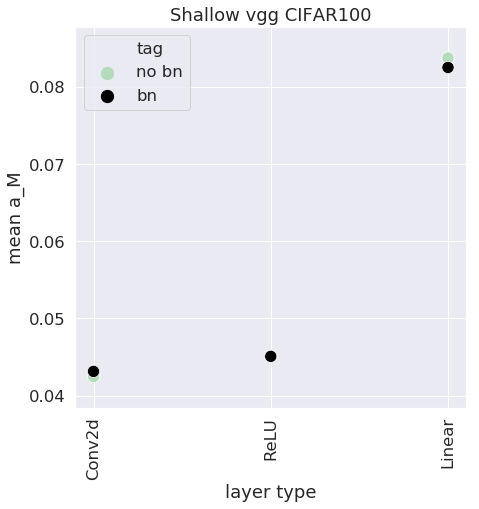

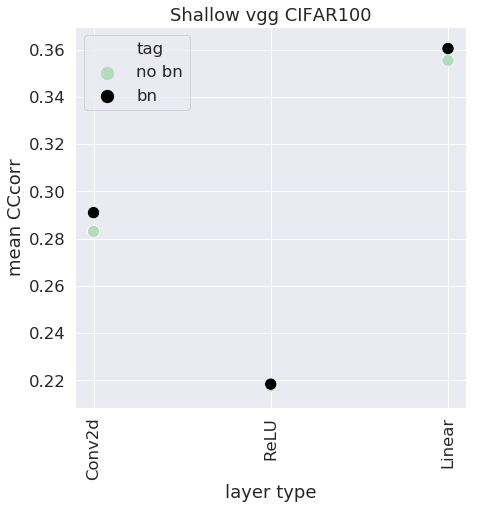

In [135]:
measures = ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']
mani_dirs = [
    '../dump/manifold_seed_1-drop_0-vgg1_sc-formatted_features-sort_random/',
    '../dump/manifold_seed_2-drop_0-vgg1_sc_bn-formatted_features-sort_random/'
]

tags = [
    "no bn",
    "bn" 
]

df = multi_frame_constructor(mani_dirs, tags, measures)

# df['tag'] = df['tag']+df['epoch'].astype(str)


df_filtered = df[(df['image set']=='train')&(df['epoch']==300)]
df_filtered = df_filtered[(df_filtered['image set']=='train')&(df_filtered['type']!='BatchNorm2d')]

# df_filtered = df[(df['image set']=='train')]
opts = {
    'dims':[7,7],
    'sortby': [],
    'hue': 'tag',
    'fix_legend':False
}

for measure in measures:
    data = display(df_filtered, measure, 'features', 'Shallow vgg CIFAR100', opts=opts)

In [7]:
mani_dirs

['../dump/manifold-seed_0-drop_0-vgg1_sc-formatted_features-sort_betasoftmax/']

In [11]:
expand_input(mani_dirs)